In [24]:
from rdkit.Chem import AllChem as Chem
from scipy.spatial import distance
from sklearn import manifold
from rdkit.Chem import Draw
from rdkit import DataStructs

from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

import matplotlib.pyplot as plt

In [5]:
supp = Chem.SDMolSupplier('../data/drugbank.sdf')
drugbank = [mol for mol in supp if mol]
fps = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in drugbank]

In [6]:
sparse_mat = distance.pdist(fps, metric="jaccard")

In [7]:
dist_mat = distance.squareform(sparse_mat)

In [8]:
clf = manifold.MDS(n_components=2, n_init =1, max_iter=10, dissimilarity ="precomputed", )
X_mds = clf.fit_transform(dist_mat)
X_mds[0:10]

array([[ 0.1384339 ,  0.16869687],
       [ 0.62459862, -0.19361611],
       [ 0.43109551,  0.42452601],
       [-0.56228508, -0.09299965],
       [-0.37932254, -0.52841698],
       [-0.62763479,  0.1942442 ],
       [-0.02715591, -0.63214689],
       [ 0.30462188, -0.58653904],
       [ 0.64072632,  0.37241666],
       [-0.34627144,  0.44972732]])

In [9]:
def mds_plot(X, *args, highlights=set()):
    plt.figure()
    ax = plt.subplot(111)
    for i, point in enumerate(X):
        x, y = point
        if i in highlights:
            plt.plot([x], [y], "r.", markersize=2)
        else:
            plt.plot([x], [y], "k.", markersize=1)

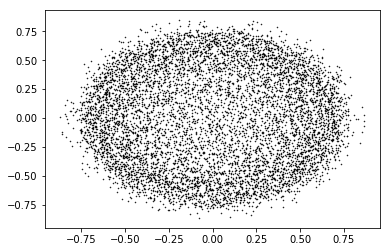

In [10]:
mds_plot(X_mds)


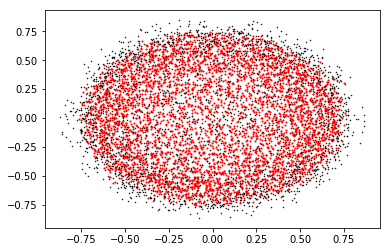

In [20]:
pattern = Chem.MolFromSmiles("c1ccccc1")
pat_idxs = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(pattern)]
mds_plot(X_mds, highlights=set(pat_idxs))

In [13]:
1-dist_mat[pat_idxs, :][:,pat_idxs]

array([[1.        , 0.37106918, 0.40714286, ..., 0.07407407, 0.12403101,
        0.11842105],
       [0.37106918, 1.        , 0.30625   , ..., 0.06666667, 0.0979021 ,
        0.1375    ],
       [0.40714286, 0.30625   , 1.        , ..., 0.08080808, 0.09677419,
        0.11034483],
       ...,
       [0.07407407, 0.06666667, 0.08080808, ..., 1.        , 0.1       ,
        0.05263158],
       [0.12403101, 0.0979021 , 0.09677419, ..., 0.1       , 1.        ,
        0.1978022 ],
       [0.11842105, 0.1375    , 0.11034483, ..., 0.05263158, 0.1978022 ,
        1.        ]])

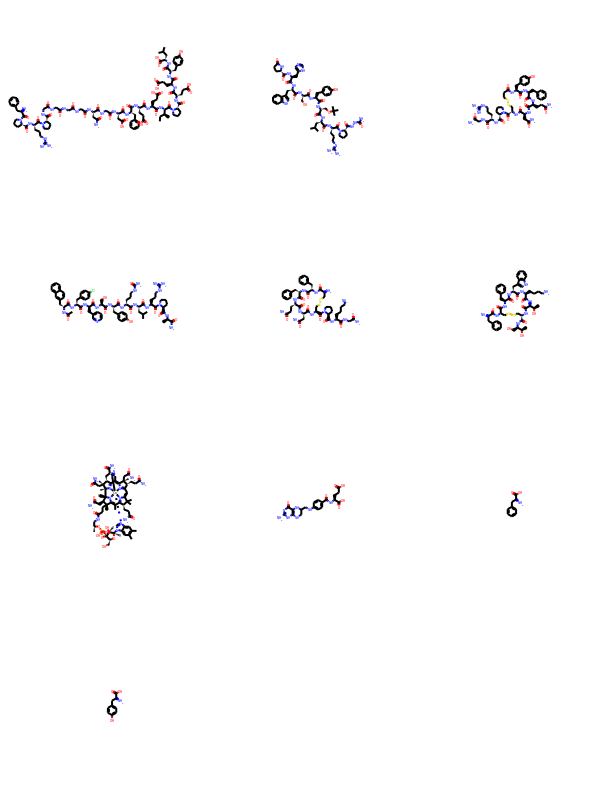

In [35]:
Draw.MolsToGridImage([mol for i,mol in enumerate(drugbank) if i in pat_idxs][:10])

In [29]:
#def distance_function(index1, index2, *args, fingerprints = fps):
#    return 1-DataStructs.FingerprintSimilarity(fingerprints[index1], fingerprints[index2])

def distance_function(index1, index2, *args, matrix = dist_mat):
    return matrix[index1, index2]

picker = MaxMinPicker()
picked_gen = picker.LazyPick(distance_function, len(drugbank), 100, seed=666)
picked = set(picked_gen)

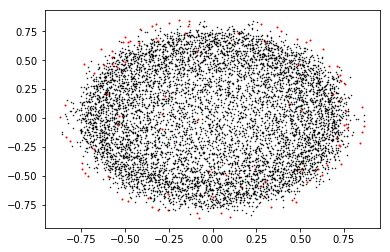

In [30]:
mds_plot(X_mds, highlights=picked)

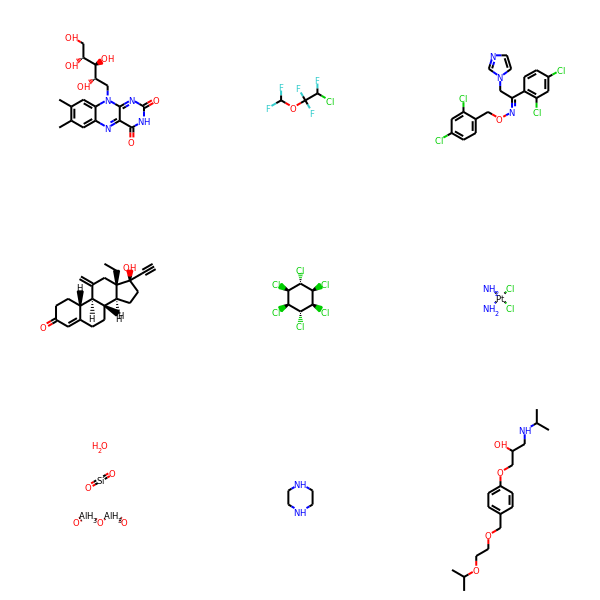

In [34]:
Draw.MolsToGridImage([mol for i,mol in enumerate(drugbank) if i in picked][1:10])

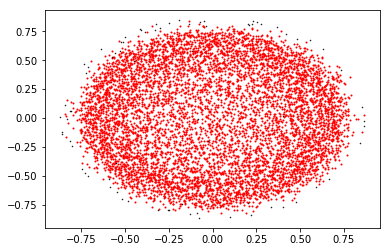

In [32]:
carbon_pat = Chem.MolFromSmarts("[#6]")
carb_idxs = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(carbon_pat)]
noncarb_idxs = [i for i, mol in enumerate(drugbank) if not mol.HasSubstructMatch(carbon_pat)]
mds_plot(X_mds, highlights=set(carb_idxs))

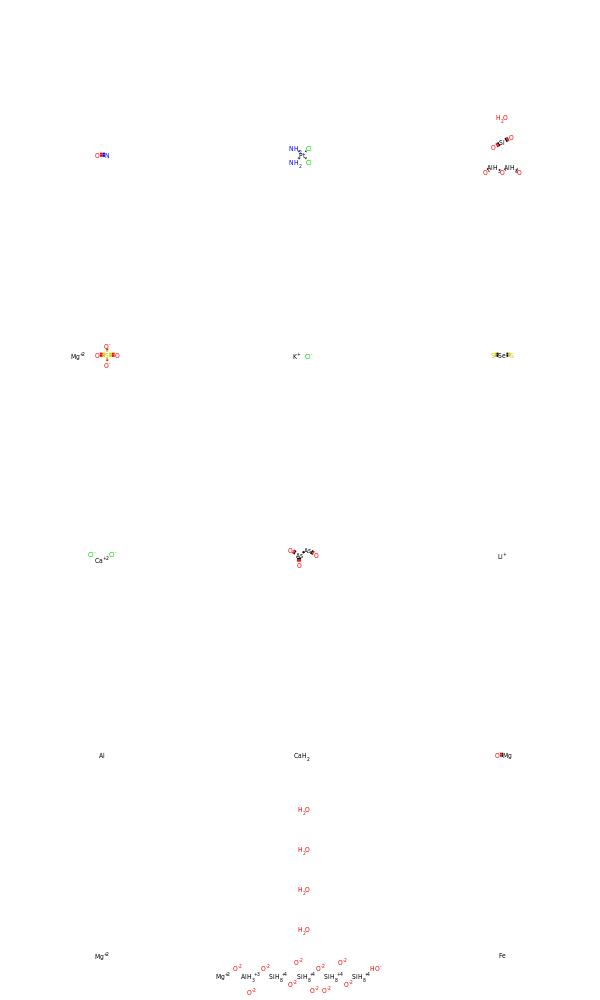

In [33]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in noncarb_idxs][:15])